# Building a matrix for numerical methods using a Landlab grid

(Greg Tucker, University of Colorado Boulder, July 2020)

*This notebook explains how to use the matrix-building functions to construct a matrix for a finite-volume or finite-difference solution on a Landlab grid.*

## Introduction

Numerical solutions to differential equations often involve matrices. With grid-based numerical models, like those that Landlab is designed to support, the problem is *discretized* in space: we solve for one or more state variables of interest at a series of discrete spatial locations, such as a grid node or the cell that surrounds it. That process of discretization converts a partial differential equation into a set of ordinary differential equations, with one equation per point. Consider, for example, the one-dimensional diffusion equation:

$$\frac{\partial \eta}{\partial t} = D\frac{\partial^2 \eta}{\partial x^2}$$

where $t$ is time, $x$ is distance, $D$ is a transport coefficient, and $\eta$ could be concentration of a dissolved chemical (classic chemical diffusion), the temperature in a solid (heat diffusion), the velocity of flow in a viscous liquid (viscous momentum diffusion), or the height of the land on a hillslope (soil diffusion). If the domain is discretized such that we seek the value of $\eta$ at a series of discrete points, then the above equation for a given point $i$ becomes:

$$\frac{d \eta_i}{d t} = D\frac{d^2 \eta}{d x^2}\bigg\rvert_i$$

where the subscript at the right means "evaluated at $i$". Once the right side has been cast in terms of values of $\eta$ at particular points, you end up with a linear system of equations, and matrix methods provide a natural way to solve them. One example among many is an implicit finite-difference solution to the one-dimensional form of the diffusion equation, which involves constructing a matrix and a "right-hand side" vector, inverting the matrix, and multiplying it by the vector to obtain a solution for the state variable at each grid node (for more on that particular example, see *Mathematical Modeling of Earth's Dynamical Systems* by Slingerland and Kump, or *Numerical Recipes* by Press et al.).

When using matrix methods to solve a set of equation at discrete points, whether in 2D or 1D (or even 3D), you typically have an $MxM$ matrix, where $M$ is the number of solution points. Each row in the matrix represents the equation for one of the points. If the equation for a given point includes terms that represent, say, two of its immediately neighboring points, then the columns representing those two points contain non-zero entries. More generally, finite-volume and finite-difference matrices tend be sparse, with only a few non-zero entries in each row: the column that represents the point itself, and the columns representing its immediate neighbors.

Building the matrix therefore requires knowledge of which points are connected to which other points in the grid. In 1D, this is easy. In 2D, it's a bit more complicated. Fortunately, the structure of a Landlab grid lends itself to this task. In particular, we know the connectivity for the *nodes* in the grid. It also turns out that when nodes are the solution points (as is typical), the number of equations---and thus $M$---corresponds exactly to the number of *core nodes* in the grid.

In the following, we first work through the mathematics in a simple example: a finite-volume matrix solution to a steady diffusion equation with a source term, also known as a Poisson equation. We then show some worked examples of the Landlab matrix tools in action.

## Example: steady diffusion with a source term

Consider the diffusion model for hillslope evolution in two dimensions. The equation describes the time evolution of land surface height, $z$, given a transport coefficient $D$ $[L^2/T]$, and relative uplift rate $U$ $[L/T]$ as:

$$\frac{\partial z}{\partial t} = U - \nabla \cdot (-D \nabla z)$$

Here $\nabla z$ is the gradient of $z$, which here is a two-element vector (components in the $x$ and $y$ directions, respectively), and $\nabla\cdot$ is the divergence operator. We'll use a matrix method to solve for $z(x)$ when the time derivative is zero. So the equation we want to solve is:

$$U \nabla \cdot (-D \nabla z) = 0$$

If $D$ is spatially uniform, we can write this as:

$$\boxed{\nabla^2 z = -U/D}$$

This is the equation we're going to discretize and solve. Here $\nabla^2$ is understood to be the divergence-of-the-gradient, and in 1D would just be a second derivative:

$$\frac{d^2z}{dx^2} = -\frac{U}{D}$$

The minus sign is important: it indicates upward convexity of the solution when $U$ and $D$ are positive (which they always are in this case).





### Finite-volume discretization

Let's take a step back in the derivation of the diffusion equation to note that it is composed of two parts together. One part is mass conservation:

$$\frac{\partial z}{\partial t} = U - \nabla \cdot \mathbf{q}$$

where $\mathbf{q}$ is soil volume flux per unit width $[L^2/T]$. The other part is the flux law:

$$\mathbf{q} = -D\nabla z$$

For this example, we'll set the time derivative to zero, meaning we are looking for a steady solution.

Next, we integrate the conservation law over a 2D region $R$. In general, $R$ is a simply connected region. Ultimately for us, it will be a grid cell, which could be a square, a rectangle, a hexagon, or even an irregular polygon.

$$\int\int_R \nabla\cdot \mathbf{q} dR = \int\int_R U dR$$

Because $U$ is constant inside the region $R$,

$$\int\int_R \nabla\cdot \mathbf{q} dR = U A_r$$

Now we apply Green's theorem, which basically says that an area integral over the divergence of a vector field is equivalent to a line integral of the surface-normal component of that vector around the perimeter of the region. Intuitively, if we consider $\mathbf{q}$ to be a flux in this case, what we're saying is that we can obtain the net total flux over the region (grid cell!) by integrating the flux all around the perimeter. Think of it as keeping track of all the people who enter or leave the perimeter of a playing field.

$$\oint_S \mathbf{q} \cdot\mathbf{n} dS = U A_r$$

where $\mathbf{n}$ is an (outward-facing) unit vector perpendicular to the perimeter $S$ that encloses region $R$. For us, again the perimeter is just the perimeter of the grid cell: the four sides of a square or rectangle, or the six side of a hexagon, the $N$ sides of a Voronoi polygon, or whatever. Then the line integral becomes a summation.

We will define a quantity $q$ that represents the face-normal component of $\mathbf{q}$. The sign convention is as follows:

- $q$ is positive if the vector orientation is toward the upper-right half space (including "right" and "up")

- $q$ is negative if the vector orientation is toward the lower-left half space (including "left" and "down")

We will also define a binary variable $\delta$, which is negative if the outward surface-normal points toward the lower-left half space, and positive if it points toward the upper-right half space.

Here's where Landlab grids come into the picture. The two definitions represent the use of *links* in a Landlab grid: when $q$ is positive when it oriented in the link's direction, and negative when oriented in the opposite direction. In a simple raster grid, where the links are all horizontal or vertical, the interpretation is very simple: flow to the right (increasing $x$) is positive, and to the left is negative; flow upward (increasing $y$) is positive, and downward is negative.

More generally, whatever the grid type, links by convention always "point" toward the upper-right half space; hence the general definition of $q$ above. The variable $\delta$ represents the link orientation relative to the cell: positive when the link points out of the cell, negative when it points into the cell. The variable is represented in a Landlab grid by the array `link_dirs_at_node`: one for each link, starting from the "east" (or "right") direction and going counter-clockwise.

Suppose $R$ is a square grid cell of width $\Delta x$. Then:

$$\oint_S \mathbf{f} \cdot\mathbf{n} dR = \sum_{k=1}^4 q_k \delta_k \Delta x$$

where $q_k$ is the magnitude of the vector field at face $k$, and $\delta = -1$ if the link at face $k$ points inward, and $+1$ if the link points outward.

For this Poisson problem (i.e., diffusion with zero time derivative), the flux between the two nodes at either end of a link is approximated as the difference in $z$ divided by the distance, which here is $\Delta x$. For each of the four directions:

$q_e = -(D/\Delta x) (z_e - z_i)$

$q_n = -(D/\Delta x) (z_n - z_i)$

$q_e = -(D/\Delta x) (z_i - z_w)$

$q_s = -(D/\Delta x) (z_i - z_s)$

Here the subscript refers to the four cardinal directions. When you work out the summation above, you get:

$$\sum_{k=1}^4 q_k \delta_k \Delta x = -D (z_e + z_n - + z_w + z_s - 4z_i)$$.

Now plug this back into our governing equation, and divide both sides by $A_r = \Delta x^2$:

$$-D (z_e + z_n - + z_w + z_s - 4z_i) = U$$

or

$$\boxed{z_e + z_n - + z_w + z_s - 4z_i = -U/D}$$

So the above represents a system of equations: one equation per core node in a Landlab grid. For any given core node, $z_i$ is the elevation of the node itself, and the other four are the elevations of its four neighbors. By the way, for a regular raster grid, this finite-volume setup turns out to be the same as the finite-difference version. Here the directional subscripts will ultimately be replaced with indices of the particular neighboring nodes.

### Example of a finite-volume setup

Suppose we have a raster model grid with 4 rows and 5 columns, so that there are 6 interior nodes. To make it interesting, let's assume that one of the interior nodes is actually a fixed-value boundary. We will also assume that the perimeter nodes are fixed-value boundaries. Fixed-value boundary simply means that we will keep the elevation constant at these nodes. In total, then, there are 5 core nodes at which we wish to solve for $z$. An illustration of the grid, with the lower-left node being node number 0, looks like:

`o---o---o---o---o
 |   |   |   |   |
 o---.---.---o---o
 |   |   |   |   |
 o---.---.---.---o
 |   |   |   |   |
 o---o---o---o---o`

In the illustration, `.` is a core node, and `o` is a fixed-value boundary node. The numbering of *nodes* looks like this:

`15---16---17---18---19
  |    |    |    |    |
 10---11---12---13---14
  |    |    |    |    |
  5--- 6--- 7--- 8--- 9
  |    |    |    |    |
  0--- 1--- 2--- 3--- 4`

Here's a version where we number the *core nodes* consecutively:

`o---o---o---o---o
 |   |   |   |   |
 o---3---4---o---o
 |   |   |   |   |
 o---0---1---2---o
 |   |   |   |   |
 o---o---o---o---o`

These numbers correspond to rows in a matrix that we will construct. For each row, the column representing the node itself gets a -4, corresponding to the boxed equation above. For each of its neighboring **core** nodes, the corresponding column gets a +1. For example, the first row in the matrix, representing core node 0 in the above sketch, will have a -4 in column 0. It will have a +1 in column 1, representing the neighbor to its east, and a +1 in column 3, representing the neighbor to its north. Here's what the matrix should look like:

\begin{vmatrix}
-4 &  1 &  0 & 1 & 0 \\
 1 & -4 &  1 & 0 & 1 \\
 0 &  1 & -4 & 0 & 0 \\
 1 &  0 &  0 & -4 & 1 \\
 0 &  1 &  0 &  1 & -4 \\
\end{vmatrix}

But what happens when one or more of the four neighbors is not another core node, but rather a fixed-value boundary? That's actually the case for *all* of the core nodes in the above example. To appreciate how this works, recall that we're going to put all the constant terms on the right-hand side of the equation. To write this out, we need a way to notate both core nodes and fixed-value nodes. Here, we'll use a subscript to index by *core node ID* (for the core nodes), and parentheses to index by *node ID* (for the boundary nodes). With that notation in mind, the equations for the example grid above are:

\begin{eqnarray}
z_1 + z_3 + z(5) + z(1) - 4z_0 = -U/D \\
z_2 + z_4 + z_0 + z(2) - 4z_1 = -U/D \\
z(9) + z(13) + z_1 + z(3) - 4z_2 = -U/D \\
z_4 + z(16) + z(10) + z_0 - 4z_3 = -U/D \\
z(13) + z(17) + z_3 + z_1 - 4z_4 = -U/D \\
\end{eqnarray}

With this notation, it's easy to spot the fixed-value boundary nodes, whose entries we'll move to the right-side:

\begin{eqnarray}
 - 4z_0 + z_1 + z_3 = -U/D - (z(5) + z(1)) \\
z_0 - 4z_1 + z_2 + z_4 = -U/D - z(2) \\
z_1 - 4z_2 = -U/D - (z(9) + z(13) + z_1 + z(3)) \\
z_0 - 4z_3 + z_4 = -U/D - (z(16) + z(10)) \\
z_1 + z_3 - 4z_4 = -U/D - (z(13) + z(17)) \\
\end{eqnarray}

The above set of equations is represented by the following matrix equation:

\begin{gather}
\begin{bmatrix}
-4 &  1 &  0 & 1 & 0 \\
 1 & -4 &  1 & 0 & 1 \\
 0 &  1 & -4 & 0 & 0 \\
 1 &  0 &  0 & -4 & 1 \\
 0 &  1 &  0 &  1 & -4 \\
\end{bmatrix}
\begin{bmatrix}
z_0 \\
z_1 \\
z_2 \\
z_3 \\
z_4
\end{bmatrix} =
\begin{bmatrix}
-U/D - (z(5) + z(1)) \\
-U/D - z(2) \\
-U/D - (z(9) + z(13) + z_1 + z(3)) \\
-U/D - (z(16) + z(10)) \\
-U/D - (z(13) + z(17))
\end{bmatrix}
\end{gather}

or more succinctly,

$$A\mathbf{z} = \mathbf{b}$$

for which the solution is

$$\mathbf{z} = A^{-1} \mathbf{b}$$

In other words this is the equation that we need to solve by inverting the matrix $A$, which we can do using `numpy.linalg.inv()`. Here's an example:

In [1]:
import numpy as np

mat = np.array([[-4,  1,  0,  1,  0],
                [ 1, -4,  1,  0,  1],
                [ 0,  1, -4,  0,  0],
                [ 1,  0,  0, -4,  1],
                [ 0,  1,  0,  1, -4],])
print(np.linalg.inv(mat))

[[-0.29353933 -0.08988764 -0.02247191 -0.08426966 -0.04353933]
 [-0.08988764 -0.31460674 -0.07865169 -0.04494382 -0.08988764]
 [-0.02247191 -0.07865169 -0.26966292 -0.01123596 -0.02247191]
 [-0.08426966 -0.04494382 -0.01123596 -0.29213483 -0.08426966]
 [-0.04353933 -0.08988764 -0.02247191 -0.08426966 -0.29353933]]


Let's assume for the sake of this example that $U=10^{-4}$ m/yr, $D=10^{-2}$ m$^2$/yr, and all the nodes around the perimeter have zero elevation. What does the solution look like in terms of numbers?

In [2]:
U = 0.0001
D = 0.01
rhs = -(U / D) + np.zeros((5, 1))
solution = np.dot(np.linalg.inv(mat), rhs)  # dot product for matrix-vector multiplication
print(solution)

[[0.00533708]
 [0.00617978]
 [0.00404494]
 [0.00516854]
 [0.00533708]]


You can see from this example that once you have your matrix and right-hand side vector, numpy's linear algebra functions make it straightforward to solve the system. The tricky part is building the matrix and the right-side vector in the first place. This is where Landlab's matrix-building utility comes in.

## Landlab's matrix-building functions

To facilitate matrix-based numerical solutions, Landlab's collection of utilities includes two helper functions:

- `get_core_node_matrix(grid, value, rhs=None)` creates and returns a matrix like $A$ above for a Landlab grid, as well as a right-hand-side vector. The matrix is returned as an M x M numpy array, where M is the number of core nodes in the grid. The right-hand-side vector is an M x 1 array. Each row in the matrix represents one core node. The rules for building a row, and the corresponding row in the right-hand-side vector, are:
  - For every *active link* connected to the node, if the link connects to another core node, the corresponding column in the matrix is assigned the value $+1$. For example, in the tiny grid presented earlier, core node 0 is connected to two other core nodes, 1 and 3. Therefore, columns 1 and 3 in row 0 of the matrix are each set to $+1$.
  - The matrix column representing the node itself is assigned a value equal to $-1$ times the number of active links that connect to the node, which represents the number of neighboring nodes that are not closed-boundary nodes. In the example grid above, core node 0 is connected for four active links, and so row 0, column 0 is set to -4.
  - All other matrix entries are zero.
  - For every neighboring *fixed-value boundary* node adjacent to core node $i$, the value at the neighbor node is subtracted from column $i$ of the right-hand side vector. This is how a fixed-value boundary condition is handled. In the example grid above, core node 0 is bordered by two fixed-value boundary nodes (node IDs 1 and 5). The values of $z$ at these two fixed-value nodes are subtracted from row 0 of the right-hand-side boundary vector.
  
- `get_core_node_matrix_var_coef(grid, value, coef_at_link=coef, rhs=None)` does basically the same thing, but allows for a spatially variable coefficient ($D$, or its equivalent in your particular problem). In the example above, we assumed that $D$ was constant, and were therefore able to move it to the right side of the equation. But there are plenty of cases where you might want to allow $D$ to vary in space. This function allows that by taking as an input a 1D array containing a value of $D$ for each grid link. The function ensures that $D$ is factored in appropropriately. (Exercise to the reader: use the example above, but with a spatially variable $D$, to work out what "appropriately" means here).  Note that when $D$ varies in space, it is included on the left side of the equation (i.e., in the matrix $A$) and **not** in the right-side vector.

Both functions return two items: an M x M array (the matrix) and an M x 1 array (for the right-hand-side vector). With both functions, however, it is your job as the user to properly set up your right-hand-side vector. You have two options. The first is to pass in an array as the `rhs` argument. It should be a 1D array of length equal to the number of core nodes. The function will then add the boundary condition information to whatever values you have already put there. The second option is to omit the `rhs` argument. In this case the function will create a "preliminary" version that contains **only** the values needed to handle fixed-value boundary conditions; you must then add the rest of your right-side information to this before solving. For example, in the sample problem above, you would need to add $-U/D$ to each element of your right-hand-side vector, while the function would take care of adding the various boundary $z$ values.

Both functions take either a `RasterModelGrid` or a `HexModelGrid` as the first argument. The matrix-creation functions work for both grid types. Note however that if you have a hex grid, you must multiply your right-hand-side vector by 3/2 (exercise: modify the derivation above, accounting for the area and side length of a hexagon, to demonstrate why this is the case). In principle, the same finite-volume solution method should work for other grid types too, but with modifications to handle spatial variation in cell area, face width, and link length. (If irregular-grid functionality is something you need for your application, we encourage you to develop it and submit a pull request!)

Both functions also take a `value` array containing the node-based values of interest (e.g., $z$ in the sample problem above). This should by a 1D numpy array of length equal to the total number of grid nodes.


## Examples using Landlab matrix functions

### Constant coefficient

The example below uses Landlab to solve the tiny sample problem described above.

Matrix:
  (0, 0)	-4.0
  (1, 0)	1.0
  (3, 0)	1.0
  (0, 1)	1.0
  (1, 1)	-4.0
  (2, 1)	1.0
  (4, 1)	1.0
  (1, 2)	1.0
  (2, 2)	-4.0
  (0, 3)	1.0
  (3, 3)	-4.0
  (4, 3)	1.0
  (1, 4)	1.0
  (3, 4)	1.0
  (4, 4)	-4.0
Right-side vector:
[[-0.01]
 [-0.01]
 [-0.01]
 [-0.01]
 [-0.01]]
Solution:
[[ 0.00533708]
 [ 0.00617978]
 [ 0.00404494]
 [ 0.00516854]
 [ 0.00533708]]


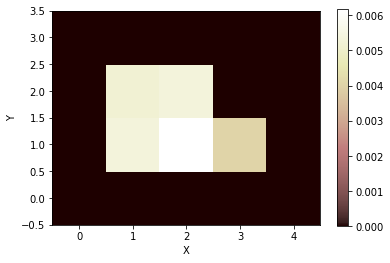

In [3]:
from landlab import RasterModelGrid, imshow_grid
from landlab.utils import get_core_node_matrix
import numpy as np

# Define parameter values
U = 0.0001  # uplift rate of material, relative to baselevel, m/yr
D = 0.01    # soil transport coefficient ("diffusivity"), m2/yr

# Create a simple grid
grid = RasterModelGrid((4, 5), xy_spacing=1.0)

# Add a field for topographic elevation
z = grid.add_zeros('topographic__elevation', at='node')

# Convert one of the interior nodes to boundary
grid.status_at_node[13] = grid.BC_NODE_IS_FIXED_VALUE

# Build the matrix and right-hand-side vector
mat, rhs = get_core_node_matrix(grid, z)

# Add the correct data to the right-hand-side vector
rhs -= U / D

# Let's take a look at them
print('Matrix:')
print(mat)
print('Right-side vector:')
print(rhs)

# Solve: invert the matrix using numpy's linalg.inv() function, then take dot product
z_core = np.dot(np.linalg.inv(mat.toarray()), rhs)
print('Solution:')
print(z_core)

# Insert the solution into the elevation field
z[grid.core_nodes] = z_core.flatten()  # flatten because z is a 1D array

# Plot
imshow_grid(grid, z)

Note that the solution for our tiny test grid is the same as before, as it should be.

### Version with a variable coefficient

Next, we repeat the above, but for a case of a spatially variable $D$. We'll first do it with an array of $D$ values, one per link, where the $D$ values are the same as above, just to demonstrate that the solution is the same.

Matrix:
  (0, 0)	-0.04
  (1, 0)	0.01
  (3, 0)	0.01
  (0, 1)	0.01
  (1, 1)	-0.04
  (2, 1)	0.01
  (4, 1)	0.01
  (1, 2)	0.01
  (2, 2)	-0.04
  (0, 3)	0.01
  (3, 3)	-0.04
  (4, 3)	0.01
  (1, 4)	0.01
  (3, 4)	0.01
  (4, 4)	-0.04
Right-side vector:
[[-0.0001]
 [-0.0001]
 [-0.0001]
 [-0.0001]
 [-0.0001]]
Solution:
[[ 0.00533708]
 [ 0.00617978]
 [ 0.00404494]
 [ 0.00516854]
 [ 0.00533708]]


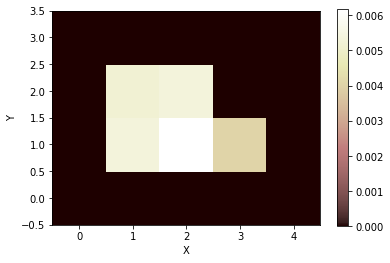

In [4]:
from landlab.utils import get_core_node_matrix

# Define an array of D values
D = 0.01 + np.zeros(grid.number_of_links)  # we could also make this a grid field if desired

# Build the matrix and right-hand-side vector
mat, rhs = get_core_node_matrix(grid, z, coef_at_link=D)

# Add the correct data to the right-hand-side vector: this time D is on the left side, so
# we don't incorporate it in the right-side vector
rhs -= U

# Let's take a look at them
print('Matrix:')
print(mat)
print('Right-side vector:')
print(rhs)

# Solve: invert the matrix using numpy's linalg.inv() function, then take dot product
z_core = np.dot(np.linalg.inv(mat.toarray()), rhs)
print('Solution:')
print(z_core)

# Insert the solution into the elevation field
z[grid.core_nodes] = z_core.flatten()  # flatten because z is a 1D array

# Plot
imshow_grid(grid, z)

Here, the matrix and RHS vector are different, but the solution is the same. We've simply factored $D$ into the left side instead of the right side.

Now let's try making $D$ actually vary in space. For the sake of illustration, we'll assign a high value to the links on the left, and a 100x lower value to the links on the right. What do you think this will do to the topography?

D values:
[ 0.1    0.1    0.001  0.001  0.1    0.1    0.1    0.001  0.001  0.1
  0.1    0.001  0.001  0.1    0.1    0.1    0.001  0.001  0.1    0.1
  0.001  0.001  0.1    0.1    0.1    0.001  0.001  0.1    0.1    0.001
  0.001]
Matrix:
  (0, 0)	-0.4
  (1, 0)	0.1
  (3, 0)	0.1
  (0, 1)	0.1
  (1, 1)	-0.301
  (2, 1)	0.001
  (4, 1)	0.1
  (1, 2)	0.001
  (2, 2)	-0.004
  (0, 3)	0.1
  (3, 3)	-0.4
  (4, 3)	0.1
  (1, 4)	0.1
  (3, 4)	0.1
  (4, 4)	-0.301
Right-side vector:
[[-0.0001]
 [-0.0001]
 [-0.0001]
 [-0.0001]
 [-0.0001]]
Solution:
[[ 0.00063011]
 [ 0.00090356]
 [ 0.02522589]
 [ 0.00061686]
 [ 0.00083735]]


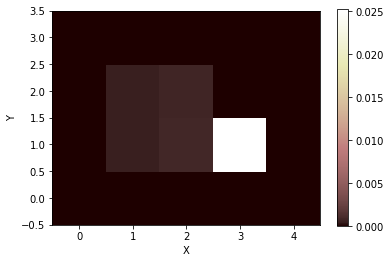

In [5]:
# Define an array of D values
D = np.zeros(grid.number_of_links)  # we could also make this a grid field if desired
D[grid.x_of_node[grid.node_at_link_head] > 2.0] = 0.001
D[grid.x_of_node[grid.node_at_link_head] <= 2.0] = 0.1
print('D values:')
print(D)

# Build the matrix and right-hand-side vector
mat, rhs = get_core_node_matrix(grid, z, coef_at_link=D)

# Add the correct data to the right-hand-side vector: this time D is on the left side, so
# we don't incorporate it in the right-side vector
rhs -= U

# Let's take a look at them
print('Matrix:')
print(mat)
print('Right-side vector:')
print(rhs)

# Solve: invert the matrix using numpy's linalg.inv() function, then take dot product
z_core = np.dot(np.linalg.inv(mat.toarray()), rhs)
print('Solution:')
print(z_core)

# Insert the solution into the elevation field
z[grid.core_nodes] = z_core.flatten()  # flatten because z is a 1D array

# Plot
imshow_grid(grid, z)

Here the lone core cell on the right is surrounded by links at which transport is inefficient; in other words, $D$ is small. Therefore, the cell needs steep slopes on all sides in order to transport out the incoming soil. The other cells are all bordered by at least one link with a high $D$ value, so they don't need much gradient to transport out the incoming material.



### Comparison with 1D analytical solution


In the next example, we'll set up an effectively 1D domain, and compare it with the known analytical solution. We can produce a quasi-1D grid by giving it just 3 rows, two of which are boundary rows, and setting the status of those boundaries to *closed*.

The expected analytical solution is a parabola:

$$z = \frac{UL^2}{D}\left(\frac{x}{L} - \frac{1}{2}\left[\frac{x}{L}\right]^2\right)$$


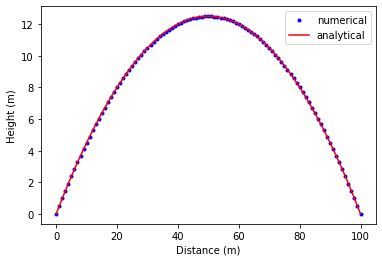

In [6]:
from landlab import RasterModelGrid, imshow_grid
from landlab.utils import get_core_node_matrix
import numpy as np

# Define parameter values
U = 0.0001  # uplift rate of material, relative to baselevel, m/yr
D = 0.01    # soil transport coefficient ("diffusivity"), m2/yr

# Create a simple grid
grid = RasterModelGrid((3, 101), xy_spacing=1.0)

# Add a field for topographic elevation
z = grid.add_zeros('topographic__elevation', at='node')

# Set closed boundaries on north and south
grid.set_closed_boundaries_at_grid_edges(False, True, False, True)

# Build the matrix and right-hand-side vector
mat, rhs = get_core_node_matrix(grid, z)

# Add the correct data to the right-hand-side vector
rhs -= U / D

# Solve: invert the matrix using numpy's linalg.inv() function, then take dot product
z_core = np.dot(np.linalg.inv(mat.toarray()), rhs)

# Insert the solution into the elevation field
z[grid.core_nodes] = z_core.flatten()  # flatten because z is a 1D array

# Calculate the analytical solution
middle_row = np.arange(101, 202, dtype=np.int)  # middle row of grid nodes
x = grid.x_of_node[middle_row]  # x coordinates: 0, 1, ... 100
L = 50.0  # half-length of domain
za = (U/D) * (x * L - 0.5 * x * x)  # analytical solution

# Plot
import matplotlib.pyplot as plt
plt.plot(x, z[middle_row], 'b.')
plt.plot(x, za, 'r')
plt.xlabel('Distance (m)')
plt.ylabel('Height (m)')
plt.legend(['numerical', 'analytical'])

### Hexagonal grid

One advantage of the finite-volume method is that it isn't limited to rectilinear grids. The next example demonstrates this with a tiny hex grid. This wee little grid has just two core nodes, so our matrix will be 2x2. One change is that we need to multiply the RHS values by 3/2 to account for the hex geometry.

In [7]:
from landlab import HexModelGrid

# Instantiate the grid: here 3 rows, with 3 columns top and bottom and 4 in the middle
hg = HexModelGrid((3, 3))

# Add the elevation field
z = hg.add_zeros('topographic__elevation', at='node')

# Constants, as before
U = 0.0001
D = 0.01
dx = 1.0  # this is the spacing between nodes

# Create the matrix and RHS
mat, rhs = get_core_node_matrix(hg, z)

# Fill in the rest of the RHS vector, including a factor of 3/2 for the hex grid.
rhs[:] += -1.5 * U * dx * dx / D

# Solve
soln = np.dot(np.linalg.inv(mat.toarray()), rhs)
z[hg.core_nodes] = soln.flatten()
print(mat)
print(rhs)
print(z)

  (0, 0)	-6.0
  (1, 0)	1.0
  (0, 1)	1.0
  (1, 1)	-6.0
[[-0.015]
 [-0.015]]
[ 0.     0.     0.     0.     0.003  0.003  0.     0.     0.     0.   ]


We can test this. The uplift rate times the cell area represents the volume rate in. Because this is a steady problem, it should equal the volume rate out. The volume rate out across any outer cell face is equal to the gradient across the face times $D$ times the width of the face. The face width in this case is $3^{-1/2}$. Here, the boundaries are all at zero and the distance between nodes is unity, so the gradient is equal to the elevation value. Hence, the flux out across any one face is:

$$3^{-1/2} Dz$$

and the total flux equals the flux of one face times the number of outer faces, of which there happen to be 10. Here's the calculation:

In [8]:
# Test: area times 2 cells times uplift rate should equal number of exposed sides times elevation
area = 0.5 * 3.0**0.5
influx = 2 * area * U
outflux = 10 * D * (1.0 / 3.0**0.5) * z[4]
print(influx)
print(outflux)

0.00017320508075688773
0.000173205080757


So, we have successfully balanced mass.

These examples have used a simple steady diffusion (Poisson) equation, cast in terms of hillslope evolution. The same equation could be used, for example, for a steady 2D heat conduction problem, or a solute injection-and-diffusion problem. And although these examples focus on the steady problem, a similar matrix-based approach can be used for implicit solutions to the time-evolving problem.


### Appendix 1: deriving a finite-element discretization for a hexagonal grid

In a regular hexagonal grid, the summation should look as derived in the following:

$$\oint_S \mathbf{f} \cdot\mathbf{n} dR = U A_r$$,

where $A_r$ is now the area of a regular hexagon. In terms of the side length, $a$, area is:

$A_r = \frac{3\sqrt{3}}{2}a^2$.

The side length relates to the height, $\Delta x$, (midpoint of one face to midpoint of the opposite face) as:

$\Delta x = \frac{3}{\sqrt{3}}a$, or

$a = \frac{\sqrt{3}}{3}\Delta x = \frac{1}{\sqrt{3}}\Delta x$.

Plugging this in for area,

$A_r = \frac{3\sqrt{3}}{2}\left( \frac{1}{\sqrt{3}} \right)^2 = \frac{\sqrt{3}}{2}\Delta x^2$.


So then our summation looks like:

$$\oint_S \mathbf{f} \cdot\mathbf{n} dR = \sum_{k=1}^6 \mathbf{q_k}\delta_k \frac{1}{\sqrt{3}}\Delta x = U \frac{\sqrt{3}}{2}\Delta x^2$$

which simplifies to

$$\sum_{k=1}^6 \mathbf{q_k}\delta_k = U \frac{3}{2}\Delta x$$

Then put in the 6 fluxes (here assuming a "horizontal" arrangement):

$q_e \delta_e = -D(1/\Delta x) (\eta_e - \eta_i)$

$q_{nne} \delta_{nne} = -D(1/\Delta x) (\eta_{nne} - \eta_i)$

$q_{nnw} \delta_{nne} = -D(1/\Delta x) (\eta_{nnw} - \eta_i)$

$q_w \delta_w = -D(1/\Delta x) (\eta_w - \eta_i)$

$q_{ssw} \delta_{ssw} = -D(1/\Delta x) (\eta_{ssw} - \eta_i)$

$q_{sse} \delta_{sse} = -D(1/\Delta x) (\eta_{ssw} - \eta_i)$

and so you get:

$$\eta_e + \eta_{nne} + \eta_{nnw} + \eta_w + \eta_{ssw} + \eta_{sse} - 6\eta_i = -\frac{3U}{2D} \Delta x^2$$

Conclusion: the only difference between a raster and a hex grid is the factor of 3/2 on the RHS, and of course the fact that you are adding up 6 neighbors instead of 4.


### Appendix 2: Deriving the analytical solution

Let $s = dz/dx$, then

$$\frac{ds}{dx} = -\frac{U}{D}$$

Assume we have a linear domain of length $2L$, in which $s(L)=0$. Integrate:

$$s = -\frac{U}{D}x + C_1$$

Evaluate the constant of integration:

$$0 = -\frac{U}{D}L + C_1$$

and therefore

$$s = \frac{dz}{dx} = \frac{U}{D}(L-x)$$

The above implies that gradient is positive when $x<L$, zero when $x=L$, and negative when $x>L$, as expected.

Now integrate again:

$$z = \frac{U}{D}\left(Lx - \frac{x^2}{2}\right) + C_2$$

Given $z(x)=z(2L)=0$, $C_2=0$, thus (and factoring out $L^2$):

$$\boxed{z = \frac{UL^2}{D}\left(\frac{x}{L} - \frac{1}{2}\left[\frac{x}{L}\right]^2\right)}$$



